# Spotify Playlist Personalisation

----

### 1. Set Environmental variables

Use auth_example.env as a sample. Provide all 3 secrets set in your spotify developer platform

* SPOTIFY_CLIENT_ID=
* SPOTIFY_CLIENT_SECRET=
* SPOTIFY_REDIRECT_URI=


In [4]:
from dotenv import load_dotenv

# Load .env file
load_dotenv()


True

### 2. Generate Token
Provide call back link to generate token for use

In [5]:
import tekore as tk
conf = tk.config_from_environment()
token = tk.prompt_for_user_token(*conf)


Opening browser for Spotify login...


### 3. Retrieving Playlist & Track Data

Reference util.py for additional functionality for data pull.

Utilising tekore package to interact with Spotify API.


In [6]:
from util import *
import asyncio
import pandas as pd

async_spotify = tk.Spotify(token = token, asynchronous=True)
uri = 'spotify:user:gingerale3'
userID = 'gingerale3'

In [7]:
import importlib
importlib.reload(util)

NameError: name 'util' is not defined

In [8]:
a = await fetch_playlists(async_spotify, userID)

In [9]:
playlist_ids = []
for i, playlist in enumerate(a):
    # if playlist.owner.uri != uri:
    #     continue
    playlist_ids.append((playlist.id, playlist.name))

In [10]:
async def get_playlist_tracks_ids(spotify, playlistID: str, playlistName: str):
    playlistTracks = []
    inital_response = await spotify.playlist_items(playlistID, limit = 1, offset = 0)
    total = inital_response.total 
    playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in inital_response.items)
    limit = 50
    numOfCalls = (total - 1)//limit + 1

    tasks = [spotify.playlist_items(playlistID, limit = limit, offset = 1 + limit * i) for i in range(numOfCalls)]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend({"playlistID": playlistID, "name": playlistName, "track": item} for item in response.items)

    return playlistTracks


In [11]:
playlistTracks = []
for i in range(len(playlist_ids)//3 + 1):
    tasks = [get_playlist_tracks_ids(async_spotify, id[0], id[1]) for id in playlist_ids[i*3:(i+1)*3]]
    responses = await asyncio.gather(*tasks)
    for response in responses:
        playlistTracks.extend(response)

In [12]:
len(playlistTracks)

2118

In [13]:
# Track id and corresponding playlist
trackId_playlist = []

for tracks in playlistTracks:
    if tracks['track'].track.id is None:
        continue
    trackId_playlist.append({'playlistID': tracks['playlistID'], 'playlistName': tracks['name'], 'id': tracks['track'].track.id})

In [14]:
len(set([(tracks['playlistID'], tracks['track'].track.id)  for tracks in playlistTracks]))

2115

In [15]:
# Get all features for tracks
track_features = await get_tracks_audio_features(async_spotify, tracks = [track['id'] for track in trackId_playlist])
track_features = [track.__dict__ for track in track_features if track is not None]
track_features_df = pd.DataFrame(track_features).drop_duplicates()
df = pd.DataFrame(trackId_playlist).merge(track_features_df, on = 'id', how = 'left')


In [16]:
# Add description playlist descriptions
len(playlist_ids)

19

In [17]:
# Create consolidate dataframe

In [23]:
features = [
    'acousticness', 
    'danceability',
    'energy',
    'instrumentalness',
    # 'key',
    'liveness',
    # 'loudness',
    # 'mode',
    'speechiness',
    # 'tempo',
    # 'time_signature',
    'valence'
]

df_clean = df.dropna(subset=features)

# ### What if i scaled the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_clean[features] = scaler.fit_transform(df_clean[features])

c:\Users\alexc\anaconda3\lib\site-packages\pandas\core\frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


### Modelling

3 Steps
* Feature extraction (can be expanded with more features). But for now lets use spotifys default features
* Clustering/classification
    *  For now lets use k means (see how can we decide how many clusters)
* Natural language generation
    * We'll construct a template for each label or category (as we get more data)
    * Can evolve using a transformer or LLM trained on a relevant dataset(this/template)




Note:

Chose to cluster tracks before giving a label. Becomes from TSNE graphical nature it was clear my playlists do vary within myself. Which aligns with my assumption.
Hence for now - perform clustering. Label the following clusters.

Can look to evolve each step


### K means clustering + Elbow/Silhouette Method

In [40]:
# Reduce Dataset to just values
X = df_clean[features].values


Based of the graphs below, going for 9 clusters

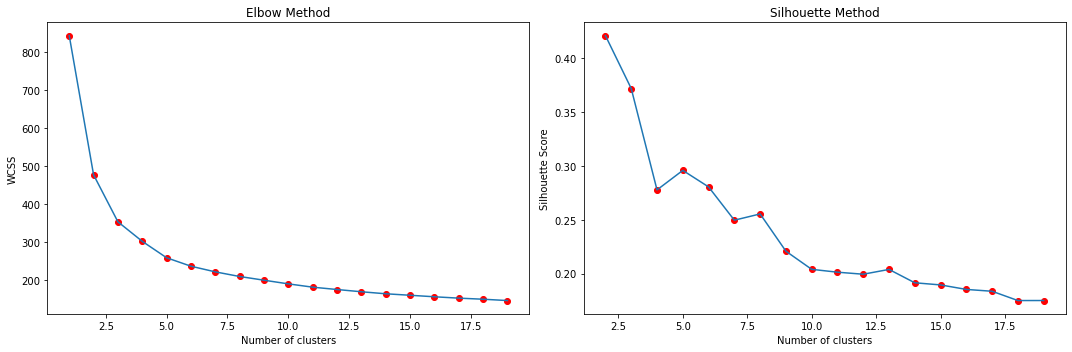

In [72]:
from sklearn.cluster import KMeans

wcss = [] # Within-Cluster Sum of Square
silhouette_scores = []

for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10).fit(X)
    #Elbow Method
    wcss.append(kmeans.inertia_)

    #Silhouette
    if i >= 2: #Requires two samples
        label = kmeans.labels_
        sil_coeff = silhouette_score(X, label, metric='euclidean')
        silhouette_scores.append(sil_coeff)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(range(1, 20), wcss)
axs[0].scatter(range(1, 20), wcss, color='red')
axs[0].set_title('Elbow Method')
axs[0].set_xlabel('Number of clusters')
axs[0].set_ylabel('WCSS')
# plt.show()



axs[1].plot(range(2, 20), silhouette_scores)
axs[1].scatter(range(2, 20), silhouette_scores, color='red')
axs[1].set_title('Silhouette Method')
axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')
# plt.show()

plt.tight_layout()
plt.show()


### Chosen algo and hyperparameter


array([[0.95983929, 0.7256439 , 0.09986706, ..., 0.09965712, 0.04840666,
        0.09483212],
       [0.47891477, 0.71780515, 0.05734669, ..., 0.10186926, 0.01984783,
        0.10325229],
       [0.85843349, 0.57334826, 0.08190499, ..., 0.11071784, 0.03506451,
        0.03841701],
       ...,
       [0.5823286 , 0.59798432, 0.70672106, ..., 0.09523283, 0.08479435,
        0.2811283 ],
       [0.02017905, 0.69092945, 0.68845455, ..., 0.08749032, 0.00661594,
        0.57688664],
       [0.75100359, 0.42777156, 0.47636009, ..., 0.07233713, 0.00904179,
        0.45374171]])

In [80]:
kmeans = KMeans(n_clusters=9, init='k-means++', max_iter=1000, n_init=10).fit(X)

In [90]:
kmeans.labels_

array([1, 3, 1, ..., 6, 8, 2])

### Visualising/Describing each cluster

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the features from the dataframe
data_subset = df_clean[features].values

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

# Add the t-SNE results back into the dataframe
df_clean['tsne-2d-one'] = tsne_results[:,0]
df_clean['tsne-2d-two'] = tsne_results[:,1]

# Create a plot
plt.figure(figsize=(16,10))

# Scatter plot for each playlist
for playlist, group in df_clean.groupby('playlistName'):
    plt.scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=playlist)

plt.legend()
plt.title('t-SNE plot colored by playlistName')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')


plt.figure(figsize=(16,10))

# Scatter plot for each playlist
for playlist, group in df_clean.groupby('playlistName'):
    if playlist == "Wolf Children": #jazspazz + gingerale3 jason's chauffeur service
        plt.scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.8, label=playlist, color='blue', s=100)  # Change color and size
    else:
        plt.scatter(group['tsne-2d-one'], group['tsne-2d-two'], alpha=0.2, label=playlist)

plt.legend()
plt.title('t-SNE plot colored by playlistName')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')

plt.show()



In [85]:
df_clean

,playlistID,playlistName,id,acousticness,analysis_url,danceability,duration_ms,energy,instrumentalness,key,...,mode,speechiness,tempo,time_signature,track_href,type,uri,valence,tsne-2d-one,tsne-2d-two
0,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,2Q7wCNeLOaOmHvQTogMSy2,0.959839,https://api.spotify.com/v1/audio-analysis/2Q7w...,0.725644,124444.0,0.099867,0.883182,11.0,...,1.0,0.048407,81.048,4.0,https://api.spotify.com/v1/tracks/2Q7wCNeLOaOm...,audio_features,spotify:track:2Q7wCNeLOaOmHvQTogMSy2,0.094832,-4.729316,-15.845506
1,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,2IsAHhoLXp6KXnGaUeL3zB,0.478915,https://api.spotify.com/v1/audio-analysis/2IsA...,0.717805,128000.0,0.057347,0.926485,2.0,...,0.0,0.019848,120.013,4.0,https://api.spotify.com/v1/tracks/2IsAHhoLXp6K...,audio_features,spotify:track:2IsAHhoLXp6KXnGaUeL3zB,0.103252,-8.740510,-12.526471
2,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,3FxNrEMsJUI9T0exSfdDwb,0.858433,https://api.spotify.com/v1/audio-analysis/3FxN...,0.573348,129065.0,0.081905,0.935549,6.0,...,0.0,0.035065,69.540,4.0,https://api.spotify.com/v1/tracks/3FxNrEMsJUI9...,audio_features,spotify:track:3FxNrEMsJUI9T0exSfdDwb,0.038417,-3.658864,-16.988810
3,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,4g9NKHADC5JzjHayUjwUdG,0.979920,https://api.spotify.com/v1/audio-analysis/4g9N...,0.723404,132923.0,0.082311,0.966767,0.0,...,1.0,0.039916,130.026,4.0,https://api.spotify.com/v1/tracks/4g9NKHADC5Jz...,audio_features,spotify:track:4g9NKHADC5JzjHayUjwUdG,0.139038,-4.563520,-15.838161
4,4yo2GyYfzYHT6aUIwsYaKC,Study / Sleep / Chill / Stream Lofi - DeadlyJimmy,7h3f29Vi8uuMJAQGEvzhgT,0.955823,https://api.spotify.com/v1/audio-analysis/7h3f...,0.671892,118182.0,0.041211,0.955690,4.0,...,0.0,0.011027,131.975,4.0,https://api.spotify.com/v1/tracks/7h3f29Vi8uuM...,audio_features,spotify:track:7h3f29Vi8uuMJAQGEvzhgT,0.080097,-4.291493,-16.380396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2113,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,3AraBEre6TrHoClhG3EqCE,0.384537,https://api.spotify.com/v1/audio-analysis/3Ara...,0.370661,178787.0,0.641773,0.000000,4.0,...,0.0,0.017973,126.981,4.0,https://api.spotify.com/v1/tracks/3AraBEre6TrH...,audio_features,spotify:track:3AraBEre6TrHoClhG3EqCE,0.290601,1.353285,-3.831088
2114,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,1MSM3Fo2fvnwVqMcz8Jhjq,0.013151,https://api.spotify.com/v1/audio-analysis/1MSM...,0.353863,223880.0,0.853868,0.000000,5.0,...,1.0,0.133311,194.000,4.0,https://api.spotify.com/v1/tracks/1MSM3Fo2fvnw...,audio_features,spotify:track:1MSM3Fo2fvnwVqMcz8Jhjq,0.221135,-9.726166,11.332402
2115,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,6W4GTXLYX8HkmZGmVkfrSC,0.582329,https://api.spotify.com/v1/audio-analysis/6W4G...,0.597984,245960.0,0.706721,0.277946,1.0,...,0.0,0.084794,120.927,4.0,https://api.spotify.com/v1/tracks/6W4GTXLYX8Hk...,audio_features,spotify:track:6W4GTXLYX8HkmZGmVkfrSC,0.281128,2.830638,-7.538478
2116,7rNTlFc5wLyjbRXzwq9Ile,2015 Birth of Indie,6MByWSkfqebVmpPw3pA1uR,0.020179,https://api.spotify.com/v1/audio-analysis/6MBy...,0.690929,186440.0,0.688455,0.016314,2.0,...,1.0,0.006616,111.037,4.0,https://api.spotify.com/v1/tracks/6MByWSkfqebV...,audio_features,spotify:track:6MByWSkfqebVmpPw3pA1uR,0.576887,2.339850,7.958677


In [84]:
kmeans.labels_

array([1, 3, 1, ..., 6, 8, 2])

In [76]:
kmeans

KMeans(max_iter=1000, n_clusters=9)